# Simple Model vs. SDSS photometric classification

This notebook compares the simple model (comparing the white PSF flux to the white Kron flux from PS1 photometry) to the independent SDSS test set. 

The SDSS data are assumed to have perfect labels from spectroscopy, and we compare the simple model to the SDSS photometric classification, which considers all sources with `psfMag - cModelMag > 0.145` to be stars.

In [43]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,zoomed_inset_axes

from scipy.stats import gaussian_kde
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

%matplotlib notebook

In [4]:
sdss = fits.getdata("sdssSP_MLfeats_adamamiller1.fit")

From the simple model we find that the optimal FoM is $a = 0.9295$

In [5]:
a = 0.9295

In [6]:
# metrics for the simple model

def calc_distance(a, x, y): # model: y = ax
    a = np.array(a)
    model = (a*x).astype(float)
    wd = (y-model)/np.sqrt(1 + a**2)
    return np.array(wd)

def calc_accuracy(a, flux1, flux2, true_class):
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    pred_class = np.array((np.sign(delta)+1)/2, dtype = int)    # psf = kron >> gal
    acc = accuracy_score(true_class, pred_class)
    return acc

def calc_roc_curve(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)    
    return fpr, tpr, thre

In [7]:
spec_galaxies = np.where(sdss["class"] == 'GALAXY')
spec_labels = np.ones_like(sdss["type"], dtype=int)
spec_labels[spec_galaxies] = 0
phot_labels = np.ones_like(sdss["type"], dtype=int)*-99
phot_labels[np.where(sdss["type"] == 3)] = 0
phot_labels[np.where(sdss["type"] == 6)] = 1

ps_dist = calc_distance(a, sdss["wwKronFlux"], sdss["wwPSFFlux"])
simple_labels = (np.sign(ps_dist).astype(int) + 1)/2

in_common = ( ((sdss["type"] == 3) | (sdss["type"] == 6))   # star or galaxy in SDSS
             & (np.isfinite(ps_dist)) )    # is detected in PS1

print("There are {:d} sources in PS1 and SDSS with spectra".format(sum(in_common)))

print("The accuracy of the SDSS photometric classifier is: {:.4f}".format(accuracy_score(spec_labels[in_common], phot_labels[in_common])))
print("The accuracy of the PS1 photometric classifier is: {:.4f}".format(accuracy_score(spec_labels[in_common], simple_labels[in_common])))

There are 3821520 sources in PS1 and SDSS with spectra
The accuracy of the SDSS photometric classifier is: 0.9597
The accuracy of the PS1 photometric classifier is: 0.9547


In [8]:
FP = len(np.where((spec_labels[in_common] == 0) & (phot_labels[in_common] == 1))[0])
TP = len(np.where((spec_labels[in_common] == 1) & (phot_labels[in_common] == 1))[0])
TN = len(np.where((spec_labels[in_common] == 0) & (phot_labels[in_common] == 0))[0])
FN = len(np.where((spec_labels[in_common] == 1) & (phot_labels[in_common] == 0))[0])
TPR = TP/(TP + FN)
FPR = FP/(FP + TN)

In [9]:
ps_fpr, ps_tpr, ps_thre = roc_curve(spec_labels[in_common], ps_dist[in_common])
sdss_fpr, sdss_tpr, sdss_thre = roc_curve(spec_labels[in_common], sdss["countRatio"][in_common])

<IPython.core.display.Javascript object>


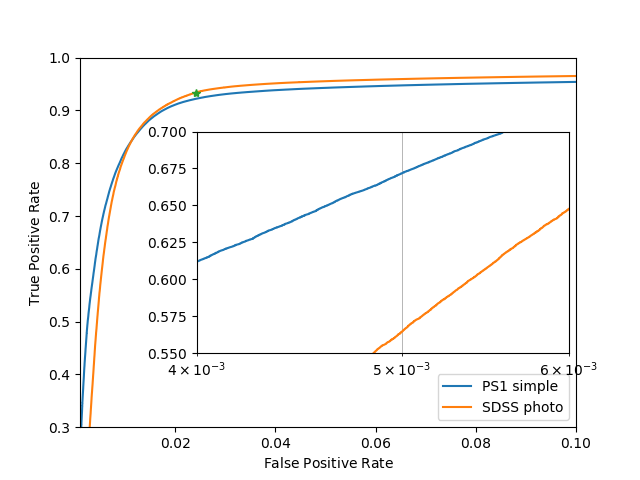

In [54]:
fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

ax.plot(ps_fpr, ps_tpr, label = "PS1 simple")
ax.plot(sdss_fpr, sdss_tpr, label = "SDSS photo")
ax.plot(FPR, TPR, '*')
axins.plot(ps_fpr, ps_tpr)
axins.plot(sdss_fpr, sdss_tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,.1)
ax.set_ylim(.3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(4e-3, 6e-3)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")

ax.legend()
# fig.tight_layout()

### Plot the accuracy as a function of magnitude

In [52]:
def plot_accuracy(Pr, Class, thre, refmag, source, Bin_Num, xlab, col, rev=False, Norm=1, plot = True, plot_ratio=False):
    Prba = np.array(Pr)
    Class = np.array(Class)
    mags = np.arange(14 , 25, 0.5)
    ratio = np.zeros(len(mags)-1)
    mag_ave = np.zeros(len(mags)-1)
    star_galaxy_ratio_max = np.zeros(len(mags)-1)
    mask_star = Pr > thre
    Prba[mask_star] = 1.0
    Prba[~mask_star] = 0.0
    data_mag = refmag
    for i in range(0, (len(mags)-1)):
        mask_mag1_i = data_mag >= mags[i]
        mask_mag2_i = data_mag < mags[i+1]
        mask_i = mask_mag1_i & mask_mag2_i
        ratio[i] = accuracy_score(np.array(Class[mask_i]).astype(float), np.array(Prba[mask_i]))
        star_ratio = np.sum(Class[mask_i] == 1)*1.0/len(Class[mask_i])
        galaxy_ratio = np.sum(Class[mask_i] == 0)*1.0/len(Class[mask_i])
        star_galaxy_ratio_max[i] = np.max([star_ratio, galaxy_ratio])
        mag_ave[i] = (mags[i]+mags[i+1])/2
    if plot:
        plt.plot(mag_ave, ratio, '--o', color=col, linewidth=3.0, label=source)
        if plot_ratio:
            plt.errorbar(x=mag_ave, y = star_galaxy_ratio_max, xerr = np.median(np.diff(mags))/2, fmt='o', alpha=0.5, color='red')
        kde = stats.gaussian_kde(np.array(data_mag[~np.isnan(data_mag)]))
        n = (np.arange(14.5,24.5,0.1))
        plt.fill(n, kde(n)*Norm-0.01+0.5, alpha=0.5, color=col)
        plt.grid(True)
        plt.xlim(np.min(mags), np.max(mags))
        plt.ylim(0.5,1.01)
        plt.xlabel(xlab , fontname='serif', fontsize=20)
        plt.ylabel("Accuracy" , fontname='serif', fontsize=20)
        plt.legend(loc="lower left")
    else: 
        return ratio

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [38]:
binwidth = 0.5
Nboot = 500
mag_array = np.arange(14 , 25, binwidth)
kron_mag = -2.5*np.log10(sdss["wwKronFlux"][in_common]/3631)
sdss_acc_arr = np.zeros_like(mag_array)
simple_acc_arr = np.zeros_like(mag_array)

sdss_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))
simple_boot_scatt = np.vstack((np.zeros_like(mag_array), np.zeros_like(mag_array)))

for bin_num, binedge in enumerate(mag_array):
    bin_sources = np.where((kron_mag >= binedge) & (kron_mag < binedge + binwidth))
    sdss_acc_arr[bin_num] = accuracy_score(spec_labels[in_common][bin_sources], 
                                           phot_labels[in_common][bin_sources])
    simple_acc_arr[bin_num] = accuracy_score(spec_labels[in_common][bin_sources], 
                                             simple_labels[in_common][bin_sources])
    sdss_boot_acc = np.empty(Nboot)
    simple_boot_acc = np.empty_like(sdss_boot_acc)
    for i in range(Nboot):
        boot_sources = np.random.choice(bin_sources[0], len(bin_sources[0]))
        sdss_boot_acc[i] = accuracy_score(spec_labels[in_common][boot_sources], 
                                           phot_labels[in_common][boot_sources])
        simple_boot_acc[i] = accuracy_score(spec_labels[in_common][boot_sources], 
                                           simple_labels[in_common][boot_sources])

    sdss_boot_scatt[:,bin_num] = np.diff(np.percentile(sdss_boot_acc, [16, 50, 84]))[::-1]
    simple_boot_scatt[:,bin_num] = np.diff(np.percentile(simple_boot_acc, [16, 50, 84]))[::-1]

In [52]:
kde = gaussian_kde(kron_mag)
n = (np.arange(14,24.5,0.1))
kde_pdf = kde(n)

<IPython.core.display.Javascript object>


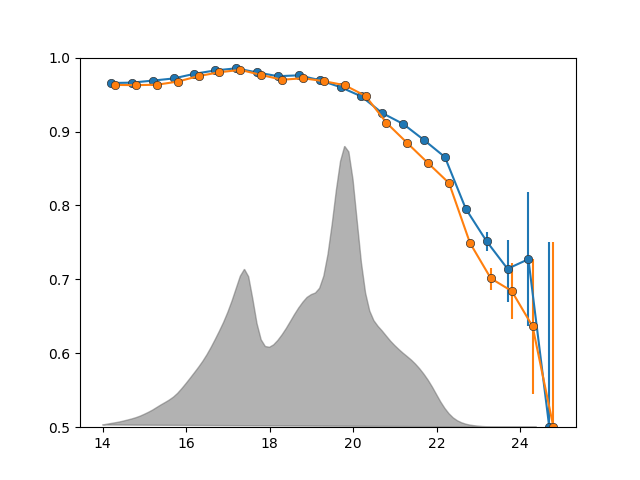

(0.5, 1)

In [53]:
fig, ax = plt.subplots()
ax.errorbar(mag_array+binwidth/2 - 0.05, 
             sdss_acc_arr, yerr = sdss_boot_scatt, 
             fmt = "o-", mec="0.2", mew=0.5)
ax.errorbar(mag_array+binwidth/2 + 0.05, 
             simple_acc_arr, yerr = simple_boot_scatt, 
             fmt = "o-", mec="0.2", mew=0.5)
ax.fill(n, kde_pdf + 0.5, alpha=0.5, color="0.4")
ax.set_ylim(0.5,1)